In [86]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.distributions as tdist

In [2]:
M = 3  # total number of datasets
N = 1000  # total number of samples
d = 5  # latent variable z dimension
y_dims = torch.tensor([20, 30, 50])  # dimensions of each dataset
x_dims = torch.tensor([4, 5, 6])


In [125]:
# slightly weird simulation seed values
def generate_W_L_Phi(y_dims, x_dims, d=5, M=3, minval=-100, maxval=100, max_noise=5):
    all_Ws = []
    all_Ls = []
    all_Phis = []
    
    for i, y_val in enumerate(y_dims):
        # declare new uniform distributions from which to sample ground truth W, L, and Phi for each dataset
        W_uniform = tdist.uniform.Uniform(torch.ones(y_val, d)*minval, torch.ones(y_val, d)*maxval)
        L_uniform = tdist.uniform.Uniform(torch.ones(y_val, x_dims[i])*minval, torch.ones(y_val, x_dims[i])*maxval)
        Phi_uniform = tdist.uniform.Uniform(torch.zeros(y_val), max_noise*torch.ones(y_val))

        # store ground truth W, L, and Phi
        all_Ws.append(W_uniform.sample())
        all_Ls.append(L_uniform.sample())
        all_Phis.append(torch.diag(Phi_uniform.sample()))
    
    return all_Ws, all_Ls, all_Phis

# standard normals for W and L, identity for Phi
def generate_W_L_gaussian_Phi_identity(y_dims, x_dims, W_stdev=2.0, L_stdev=2.0):
    all_Ws = []
    all_Ls = []
    all_Phis = []
    
    for i, y_val in enumerate(y_dims):
        # declare new uniform distributions from which to sample ground truth W, L, and Phi for each dataset
        W_dist = tdist.normal.Normal(torch.zeros(y_val, d), torch.ones(y_val, d) * W_stdev)
        L_dist = tdist.normal.Normal(torch.zeros(y_val, x_dims[i]), torch.ones(y_val, x_dims[i]) * L_stdev)

        # store ground truth W, L, and Phi
        all_Ws.append(W_dist.sample())
        all_Ls.append(L_dist.sample())

        # append identity matrix instead of sampling uniform values
        all_Phis.append(torch.eye(y_val))
        
    return all_Ws, all_Ls, all_Phis


In [126]:
# all_Ws, all_Ls, all_Phis = generate_W_L_Phi(y_dims, x_dims)
all_Ws, all_Ls, all_Phis = generate_W_L_gaussian_Phi_identity(y_dims, x_dims)
print([W.shape for W in all_Ws])
print([L.shape for L in all_Ls])
print([Phi.shape for Phi in all_Phis])

[torch.Size([20, 5]), torch.Size([30, 5]), torch.Size([50, 5])]
[torch.Size([20, 4]), torch.Size([30, 5]), torch.Size([50, 6])]
[torch.Size([20, 20]), torch.Size([30, 30]), torch.Size([50, 50])]


In [127]:
def generate_samples(all_Ws, all_Ls, all_Phis, y_dims, x_dims, N=1000, d=5):
    datasets = [torch.zeros(1, y_d) for y_d in y_dims]

    # z-distribution remains fixed
    z_distribution = tdist.multivariate_normal.MultivariateNormal(torch.zeros(d), torch.eye(d))
    
    # simulate the graphical model
    for sample in range(N):
        print('Generating sample: {}/{}'.format(sample, N), end='\r', flush=True)
        # for each sample, retrieve the latent z latent variable
        z = z_distribution.sample()
        # for each dataset, compute the dataset-specific mean and variance, and obtain 1 sample
        for i, dim in enumerate(x_dims):
            x = tdist.multivariate_normal.MultivariateNormal(torch.zeros(dim), torch.eye(dim)).sample()
            y_i = tdist.multivariate_normal.MultivariateNormal(all_Ws[i] @ z + all_Ls[i] @ x, all_Phis[i]).sample()
            datasets[i] = torch.cat([datasets[i], y_i[None,:]])
    datasets = [dataset[1:] for dataset in datasets]      
    return datasets

In [128]:
# generate datasets according to simulation
datasets = generate_samples(all_Ws, all_Ls, all_Phis, y_dims, x_dims)
# concatenate the y-vectors for each sample together
y_concat = torch.cat(datasets, axis=1)
y_concat_T = y_concat.T
print(y_concat_T.shape)

torch.Size([100, 1000])1000


In [163]:
# we have the low-rank structure and shit here
def initialize_model(y_dims, x_dims, datasets, d=5, std=1, mean=0):
    Ws_to_stack = []
    Phis_to_stack = []
    Ls_to_stack = []
    
    for i, y_dim in enumerate(y_dims):
        # set W and L to standard normal initialization around 0 
        cur_W = torch.nn.init.normal_(torch.zeros(y_dim, d), mean=mean, std=std)
        cur_L = torch.nn.init.normal_(torch.zeros(y_dim, x_dims[i]), mean=mean, std=std)

        # set Phi to the empirical covariance matrix 
        cur_dataset = datasets[i] # (n_samples x dimension)
        ymu = torch.mean(cur_dataset, axis=0, keepdim=True)
        cur_dataset = cur_dataset - ymu
        
        # due to design matrix construction, covariance = 1/n(Y^T Y)
        cur_Phi = (1/cur_dataset.shape[0]) * cur_dataset.T @ cur_dataset

        Ws_to_stack.append(cur_W)
        Ls_to_stack.append(cur_L)
        Phis_to_stack.append(cur_Phi)

    return torch.cat(Ws_to_stack, axis=0), torch.block_diag(*Ls_to_stack), torch.block_diag(*Phis_to_stack)


In [164]:
# compute the ground-truth parameters
W_GT = torch.cat(all_Ws, axis=0)
L_GT = torch.block_diag(*all_Ls)
Phi_GT = torch.block_diag(*all_Phis)
# initialize the model parameters
W_model, L_model, Phi_model = initialize_model(y_dims, x_dims, datasets)

In [178]:
# the E-Step required values (is there a way to batch this intelligently?)
def E_step(W, L, Phi, x_dims, d, y_i):
    # schur-complement (M/D)^{-1}; need to make sure that this is not blowing up!
    sigma_22_inv = torch.inverse(W@W.T + L @ L.T + Phi)
    #     print(sigma_22_inv)

    # other necessary block matrices
    sigma_12 = torch.cat([W.T, L.T], axis=0)
    sigma_11 = torch.eye(torch.sum(x_dims)+d)

    # compute the posterior mean of z and x; y should be a matrix with all samples aligned as columns
    posterior_z_x_mean = sigma_12 @ sigma_22_inv @ (y_i)
    posterior_z_mean = posterior_z_x_mean[:d]
    posterior_x_mean = posterior_z_x_mean[d:]

    # posterior covariance
    posterior_x1_cov = sigma_11 - sigma_12 @ sigma_22_inv @ sigma_12.T
    posterior_z_x_cov = posterior_x1_cov[:d, d:]  # cross covariance
    posterior_z_z_cov = posterior_x1_cov[:d, :d]  # upper left block matrix
    posterior_x_x_cov = posterior_x1_cov[d:, d:]  # bottom right block matrix
    
    # need to batch zmu and xmu: [n_samples, <[z, x]>.shape, 1]
    zmu_batched = posterior_z_mean.T[:, :, None]
    xmu_batched = posterior_x_mean.T[:, :, None]

    # posterior <zx.T> = cov(z, x) + <z><x.T>
    posterior_zxT = posterior_z_x_cov + zmu_batched @ xmu_batched.permute(0, 2, 1)  # shape: (n_samples, z_dim, x_dim)
    posterior_zzT = posterior_z_z_cov + zmu_batched @ zmu_batched.permute(0, 2, 1)  # shape: (n_samples, z_dim, z_dim)
    posterior_xxT = posterior_x_x_cov + xmu_batched @ xmu_batched.permute(0, 2, 1)  # shape: (n_samples, x_dim, x_dim)

    return posterior_zxT, posterior_zzT, posterior_xxT, zmu_batched, xmu_batched
def M_step(zxT, zzT, xxT, zmu, xmu, y_i, Phi_model, L_model, W_model, N):
    y_i_batched = y_i[:, :, None]  # (n_samples, batch_dim, 1)
    new_L = torch.sum(y_i_batched @ xmu.permute(0, 2, 1) - W_model @ zxT, axis=0) @ torch.inverse(torch.sum(xxT, axis=0))
    new_W = torch.sum(y_i_batched @ zmu.permute(0, 2, 1) - L_model @ zxT.permute(0, 2, 1), axis=0) @ torch.inverse(torch.sum(zzT, axis=0))
    
    phi_term_1 = 2 / N * torch.sum( (L_model @ xmu + W_model @ zmu) @ y_i_batched.permute(0, 2, 1), axis=0)
    phi_term_2 = -1 / N * torch.sum(y_i_batched @ y_i_batched.permute(0, 2, 1), axis=0)
    phi_term_3 = -1 / N * torch.sum( (L_model @ xxT @ L_model.T) + W_model @ zzT @ W_model.T + 2 * L_model @ zxT.permute(0, 2, 1) @ W_model.T, axis=0)
    new_Phi = torch.inverse(phi_term_1 + phi_term_2 + phi_term_3)

    #     print(phi_term_1.shape)
    #     print(phi_term_2.shape)
    #     print(new_L.shape)
    #     print(new_W.shape)    
    
    return new_W, new_L, new_Phi

In [179]:
zxT, zzT, xxT, zmu, xmu = E_step(W_model, L_model, Phi_model, x_dims, d, y_concat_T)
new_W, new_L, new_Phi = M_step(zxT, zzT, xxT, zmu, xmu, y_concat, Phi_model, L_model, W_model, N)

----------------------------------------------------------------------------------------------------
Initial F-Norm (W-WGT)_F: 49.89502716064453 (L-LGT)_F: 51.235958099365234 (Phi-PhiGT)_F: 0.0
----------------------------------------------------------------------------------------------------
0/1000: (W-WGT)_F: 49.89502716064453 (L-LGT)_F: 51.235958099365234 (Phi-PhiGT)_F: 0.0
50/1000: (W-WGT)_F: 69.72433471679688 (L-LGT)_F: 80.46775817871094 (Phi-PhiGT)_F: 0.0
100/1000: (W-WGT)_F: 65.29612731933594 (L-LGT)_F: 78.29511260986328 (Phi-PhiGT)_F: 0.0
150/1000: (W-WGT)_F: 62.482093811035156 (L-LGT)_F: 77.10384368896484 (Phi-PhiGT)_F: 0.0
200/1000: (W-WGT)_F: 60.50444793701172 (L-LGT)_F: 76.28849792480469 (Phi-PhiGT)_F: 0.0
250/1000: (W-WGT)_F: 59.04951858520508 (L-LGT)_F: 75.63645935058594 (Phi-PhiGT)_F: 0.0
300/1000: (W-WGT)_F: 57.9642219543457 (L-LGT)_F: 75.0776138305664 (Phi-PhiGT)_F: 0.0
350/1000: (W-WGT)_F: 57.15309524536133 (L-LGT)_F: 74.58623504638672 (Phi-PhiGT)_F: 0.0
400/1000: (W

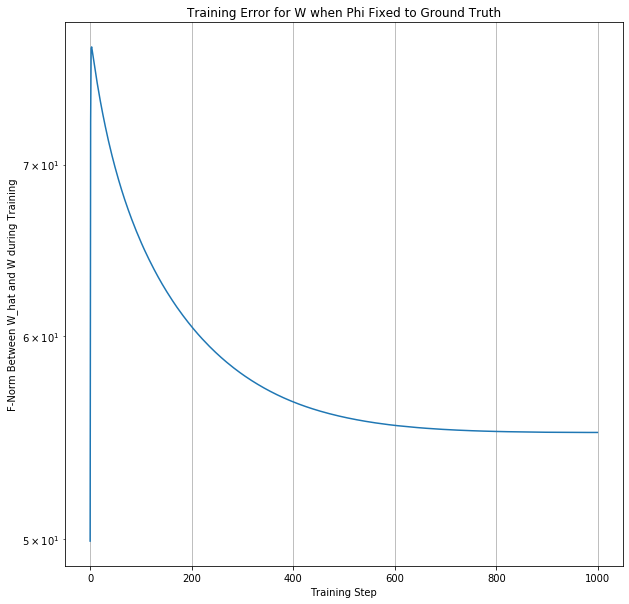

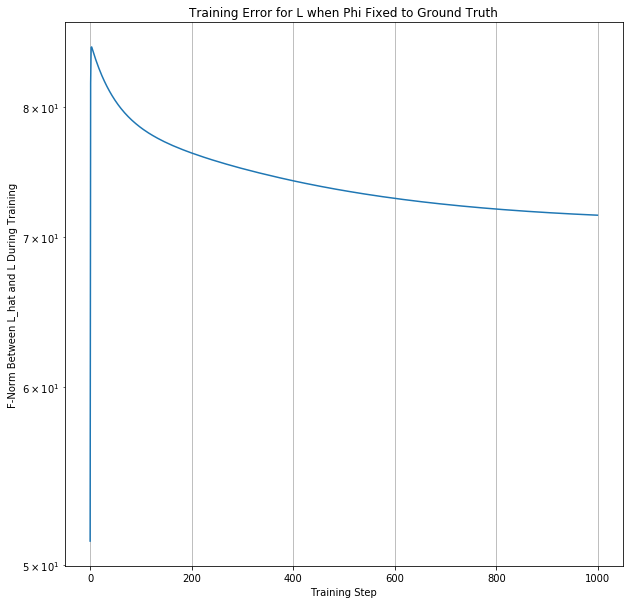

<Figure size 720x720 with 0 Axes>

In [180]:
# Experiment Set Phi = Phi_GT and don't update it in the M-Step
plt.rcParams['figure.figsize'] = (10, 10)
def M_step(zxT, zzT, xxT, zmu, xmu, y_i, Phi_model, L_model, W_model, N):
    y_i_batched = y_i[:, :, None]  # (n_samples, batch_dim, 1)
    new_L = torch.sum(y_i_batched @ xmu.permute(0, 2, 1) - W_model @ zxT, axis=0) @ torch.inverse(torch.sum(xxT, axis=0))
    new_W = torch.sum(y_i_batched @ zmu.permute(0, 2, 1) - L_model @ zxT.permute(0, 2, 1), axis=0) @ torch.inverse(torch.sum(zzT, axis=0))
    new_Phi = Phi_model # Experiment Set Phi = Phi_GT and don't update it in the M-Step

    return new_W, new_L, new_Phi


# number of E/M-Steps To Run
steps = 1000
# initialize the model parameters
W_model, L_model, Phi_model = initialize_model(y_dims, x_dims, datasets)
# stop training when the F-norm b/w current/prev update is too small
eps = 1e-3

# ground truth (GT) values
W_GT = torch.cat(all_Ws, axis=0)
L_GT = torch.block_diag(*all_Ls)
Phi_GT = torch.block_diag(*all_Phis)

# EXPERIMENT: Set Phi=Phi_GT and never update it; do we get convergence?
Phi_model = Phi_GT

# Check initial F-Norm
W_norm = torch.norm(W_GT - W_model).item()
L_norm = torch.norm(L_GT - L_model).item()
Phi_norm = torch.norm(Phi_GT - Phi_model).item()
print("-"*100)
print("Initial F-Norm (W-WGT)_F: {} (L-LGT)_F: {} (Phi-PhiGT)_F: {}".format(W_norm, L_norm, Phi_norm))
print("-"*100)

# store the reconstruction error
W_losses = []
L_losses = []
Phi_losses = []

# iterate through E/M Steps
for i in range(steps):
    # E-Step, then M-Step
    zxT, zzT, xxT, zmu, xmu = E_step(W_model, L_model, Phi_model, x_dims, d, y_concat_T)
    W_tprime, L_tprime, Phi_tprime = M_step(zxT, zzT, xxT, zmu, xmu, y_concat, Phi_model, L_model, W_model, N)

    # F-norm between current estimators and true values
    W_norm = torch.norm(W_GT - W_model).item()
    L_norm = torch.norm(L_GT - L_model).item()
    Phi_norm = torch.norm(Phi_GT - Phi_model).item()

    # F-norm between prev params and updated
    W_diff = torch.norm(W_tprime-W_model).item()
    L_diff = torch.norm(L_tprime-L_model).item()
    Phi_diff = torch.norm(Phi_tprime - Phi_model).item()

    # store training stats
    W_losses.append(W_norm)
    L_losses.append(L_norm)
    Phi_losses.append(Phi_norm)
    
    # update parameters
    W_model = W_tprime
    L_model = L_tprime
    Phi_model = Phi_tprime

    if W_diff <= eps and L_diff <= eps and Phi_diff <= eps:
        print('Stopping... step between W_t, W_t+1 <= {}'.format(eps))
        break

    if (i % 50 == 0):
        print("{}/{}: (W-WGT)_F: {} (L-LGT)_F: {} (Phi-PhiGT)_F: {}".format(i, steps, W_norm, L_norm, Phi_norm))

W_norm = torch.norm(W_GT - W_model).item()
L_norm = torch.norm(L_GT - L_model).item()
Phi_norm = torch.norm(Phi_GT - Phi_model).item()

print("-"*100)
print("Steps: {} (W-WGT)_F: {} (L-LGT)_F: {} (Phi-PhiGT)_F: {}".format(i, W_norm, L_norm, Phi_norm))
plt.plot(np.arange(i+1), W_losses)
plt.grid()
plt.yscale('log')
plt.ylabel('F-Norm Between W_hat and W during Training')
plt.xlabel('Training Step')
plt.title('Training Error for W when Phi Fixed to Ground Truth')
plt.savefig('./phi_fixed_updates_to_W.png')
plt.show()
plt.clf()
plt.plot(np.arange(i+1), L_losses)
plt.grid()
plt.yscale('log')
plt.ylabel('F-Norm Between L_hat and L During Training')
plt.xlabel('Training Step')
plt.title('Training Error for L when Phi Fixed to Ground Truth')
plt.savefig('./phi_fixed_updates_to_L.png')
plt.show()
plt.clf()



In [184]:
(W_model - W_GT).abs().mean()

tensor(1.9572)